In [1]:
# import rasterio 
import numpy as np
import glob
import cv2
import uuid
from pathos.pools import ThreadPool as pp
import os
import tifffile as tiff
import matplotlib.pyplot as plt
from tqdm import tqdm
from copy import deepcopy

## Vaihingen

In [56]:
NClasses = 6 # Looking at the data I am treating "background" as a separate class. 
Background = np.array([255,0,0]) #:{'name':'Background','cType':0},
ImSurf = np.array ([255,255,255])# :{'name':'ImSurf','cType':1},
Car = np.array([255,255,0]) # :{'name':'Car','cType':2},
Building = np.array([0,0,255]) #:{'name':'Building','cType':3},
LowVeg = np.array([0,255,255]) # :{'name':'LowVeg','cType':4},
Tree = np.array([0,255,0]) # :{'name':'Tree','cType':5}

# READING DATA 
# @@@@@@@@@@@@@@@@@ REPLACE THIS WITH YOUR DATA DIRECTORY 
read_prefix= 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\'
# prefix_imgs = 'top\\'
prefix_imgs = 'test_top\\'
prefix_dems = 'dsm\\'
# prefix_labels = 'gts_complete\\'
prefix_labels = 'test_mask\\'

flnames_imgs = sorted(glob.glob(read_prefix+prefix_imgs+'*.tif'))
flnames_dems = sorted(glob.glob(read_prefix+prefix_dems+'*.tif'))
flnames_labels = sorted(glob.glob(read_prefix+prefix_labels+'*.tif'))

IDs = []
for name in flnames_labels:
#     IDs +=[name.replace(read_prefix + 'gts_complete\\top_mosaic_09cm_area','').replace('.tif', '')]
    IDs +=[name.replace(read_prefix + 'test_mask\\top_mosaic_09cm_area','').replace('.tif', '')]

# Read img names and corresponding masks. 
Filter = 256 # Window size of patches
stride =  Filter // 2 # This is the stride so as to capture edge effects. 
# stride = Filter
length_scale = 0.317 # when squared gives ~ 0.1, i.e. 10% of all area
# length_scale = 0

prefix_global_write = 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\'

In [57]:
print(IDs)

for im in flnames_imgs:
    print(tiff.imread(im).shape)

['1', '2']
(2569, 1919, 3)
(2767, 2428, 3)


## US3D

In [3]:
# # READING DATA 
# # @@@@@@@@@@@@@@@@@ REPLACE THIS WITH YOUR DATA DIRECTORY 
# read_prefix= 'C:\\Users\\vmars\\Desktop\\phd\\dfc2019-master\\Track1-train-RGB\\'
# # prefix_imgs = 'RGB\\'
# prefix_imgs = 'test_RGB\\'
# prefix_dems = 'dsm\\'
# # prefix_labels = 'CLS\\'
# prefix_labels = 'test_CLS\\'

# flnames_imgs = sorted(glob.glob(read_prefix+prefix_imgs+'*.tif'))
# flnames_dems = sorted(glob.glob(read_prefix+prefix_dems+'*.tif'))
# flnames_labels = sorted(glob.glob(read_prefix+prefix_labels+'*.tif'))

# IDs = []
# for name in flnames_labels:
#     IDs +=[name.replace(read_prefix + 'test_CLS\\','').replace('_CLS.tif', '')]
# #         IDs +=[name.replace(read_prefix + 'CLS\\','').replace('_CLS.tif', '')]

# # Read img names and corresponding masks. 
# Filter = 256 # Window size of patches
# stride =  Filter // 2 # This is the stride so as to capture edge effects. 
# length_scale = 0.317 # when squared gives ~ 0.1, i.e. 10% of all area
# NClasses = 5

# ###prefix_global_write = r'/flush1/dia021/isprs_potsdam/Data_6k/'
# prefix_global_write = 'C:\\Users\\vmars\\Desktop\\phd\\dfc2019-master\\Track1-train-RGB\\dataset\\'

## Potsdam

In [ ]:
# # READING DATA 
# # @@@@@@@@@@@@@@@@@ REPLACE THIS WITH YOUR DATA DIRECTORY 
# # read_prefix= r'C:/Users/vmars/Desktop/phd/dataset/dataset_Potsdam/'
# read_prefix= 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\dataset_Potsdam\\'
# prefix_imgs = '4_Ortho_RGBIR\\'
# prefix_dems = '1_DSM_normalisation\\'
# prefix_labels = '5_Labels_for_participants\\'

# flnames_imgs = sorted(glob.glob(read_prefix+prefix_imgs+'*.tif'))
# flnames_dems = sorted(glob.glob(read_prefix+prefix_dems+'*.tif'))
# flnames_labels = sorted(glob.glob(read_prefix+prefix_labels+'*.tif'))

# IDs = []
# for name in flnames_labels:
#     IDs +=[name.replace(read_prefix + '5_Labels_for_participants\\top_potsdam_','').replace('_label.tif','')]


# # Read img names and corresponding masks. 
# Filter = 256 # Window size of patches
# stride =  Filter // 2 # This is the stride so as to capture edge effects. 
# length_scale = 0.317 # when squared gives ~ 0.1, i.e. 10% of all area


# prefix_global_write = 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\dataset_Potsdam\\Data_6k\\'
# # prefix_global_write = r'C:/Users/vmars/Desktop/phd/dataset/dataset_Potsdam/Data_6k/'


# # # PARAMS
# # im_size = 6000
# # dem = True

#### Helper functions

In [58]:
# Helper functions to create boundary and distance transform
# Expect ground trouth label in 1hot format 
# Necessary for fixing an error in the data: 
def img_transform(_img, im_size):
#     _nchannels=_img.shape[0]
#     print(_nchannels)
#     _img = np.transpose(_img,[1,2,0])
    img = cv2.resize(_img,(im_size[0],im_size[1]),interpolation= cv2.INTER_NEAREST)
    #img = transform.resize(img,(new_size,new_size,_nchannels),preserve_range=True)
    if len(img.shape) == 2:
        img = np.expand_dims(img, 0)
    else:
        img = np.transpose(img,[2,0,1])
    #img = img.astype('uint8')
    
    return img


def get_boundary(labels, _kernel_size = (3,3)):
    
    label = labels.copy()
    for channel in range(label.shape[0]):
        temp = cv2.Canny(label[channel],0,1)
        label[channel] = cv2.dilate(temp, cv2.getStructuringElement(cv2.MORPH_CROSS,_kernel_size) ,iterations = 1)
    
    label = label.astype(np.float32)
    label /= 255.
    #label = label.astype(np.uint8)
    return label

def get_distance(labels):
    label = labels.copy()
#     print(label.shape)
    dists = np.empty_like(label,dtype=np.float32)
    for channel in range(label.shape[0]):
        dist = cv2.distanceTransform(label[channel], cv2.DIST_L2, 0)
        dist = cv2.normalize(dist, dist, 0, 1.0, cv2.NORM_MINMAX)
        dists[channel] = dist
        
    return dists

def ID_2_filenames(_ID, dataset = 'vaihingen'):
    
    if (len(_ID[2:]) == 1 ):
        ID_dsm = '0'+_ID[0]+'_'+'0'+_ID[2]
    else:
        ID_dsm = '0'+_ID
    
    if dataset == 'potsdam':
        label_name = r'top_potsdam_' + _ID + '_label.tif'
        dsm_name = r'dsm_potsdam_' + ID_dsm + '_normalized_lastools.jpg'
        img_name = r'top_potsdam_'+_ID + '_RGBIR.tif'
    elif dataset == 'vaihingen':
        label_name = r'top_mosaic_09cm_area' + _ID + '.tif'
        dsm_name = r'top_mosaic_09cm_area' + _ID + '.tif'
        img_name = r'top_mosaic_09cm_area' + _ID + '.tif'
    elif dataset == 'us3d':
        label_name = _ID + '_CLS.tif'
        dsm_name = _ID + '_CLS.tif' #FINTO
        img_name = _ID + '_RGB.tif'
    
    return label_name, img_name, dsm_name 

def read_n_stack(_ID, im_size, dem = True, dataset = 'vaihingen'):
    """
    Given and ID string, returns stacked img (RGBIR+DEMS) and label (RGB)
    It fixes a bug in the data, one having dimension one pixel less 
    """
    tflname_label, tflname_img, tflname_dems = ID_2_filenames(_ID, dataset)
    
    tflname_label = read_prefix + prefix_labels + tflname_label
    tflname_img = read_prefix + prefix_imgs + tflname_img
    tflname_dems = read_prefix + prefix_dems + tflname_dems
    
        
    # read label: 
#     with rasterio.open(tflname_label) as src:
#         label = src.read()
    label = tiff.imread(tflname_label)
    if label.shape[1:] != (im_size[0],im_size[1]):
        label = img_transform(label, im_size)

    # read image
#     with rasterio.open(tflname_img) as src:
#         img = src.read()
    img = tiff.imread(tflname_img)
    if img.shape[1:] != (im_size[0],im_size[1]):
        img = img_transform(img, im_size)
        
    if dem:
        # read DEMs
#         with rasterio.open(tflname_dems) as src:
#             dems = src.read()
        dems = tiff.imread(tflname_dems)
        if dems.shape[1:] != (im_size[0],im_size[1]):
            dems = img_transform(dems, im_size)

        img = np.concatenate([img,dems],axis=0)

    return img, label
    
    
# Fast version to translate class RGB tuples to integer indices
def rgb_to_2D_label(_label):
#     label_seg = np.zeros(_label.shape[1:],dtype=np.uint8)
#     label_seg [np.all(_label.transpose([1,2,0])==Background,axis=-1)] = 0
#     label_seg [np.all(_label.transpose([1,2,0])==ImSurf,axis=-1)] = 1
#     label_seg [np.all(_label.transpose([1,2,0])==Car,axis=-1)] = 2
#     label_seg [np.all(_label.transpose([1,2,0])==Building,axis=-1)] = 3
#     label_seg [np.all(_label.transpose([1,2,0])==LowVeg,axis=-1)] = 4
#     label_seg [np.all(_label.transpose([1,2,0])==Tree,axis=-1)] = 5

    label_seg = np.zeros(_label.shape[:-1], dtype=np.uint8)
    label_seg [np.all(_label==Background,axis=-1)] = 0
    label_seg [np.all(_label==ImSurf,axis=-1)] = 1
    label_seg [np.all(_label==Car,axis=-1)] = 2
    label_seg [np.all(_label==Building,axis=-1)] = 3
    label_seg [np.all(_label==LowVeg,axis=-1)] = 4
    label_seg [np.all(_label==Tree,axis=-1)] = 5
    
    return label_seg


# translates image to 1H encoding
def rgb_to_1H_label(_label, dataset = 'vaihingen'):
#     Filter = 256
#     label_seg = np.zeros([*_label.shape[1:],NClasses],dtype=np.uint8)
#     label_seg [np.all(_label.transpose([1,2,0])==Background,axis=-1)] = teye[0]
#     label_seg [np.all(_label.transpose([1,2,0])==ImSurf,axis=-1)] = teye[1]
#     label_seg [np.all(_label.transpose([1,2,0])==Car,axis=-1)] = teye[2]
#     label_seg [np.all(_label.transpose([1,2,0])==Building,axis=-1)] = teye[3]
#     label_seg [np.all(_label.transpose([1,2,0])==LowVeg,axis=-1)] = teye[4]
#     label_seg [np.all(_label.transpose([1,2,0])==Tree,axis=-1)] = teye[5]
    if dataset == 'us3d':      
#         print(_label.shape)
        x = las_to_sequential_labels(_label)
#         print(x.shape)
        label_seg = category_label(x, (1024,1024), NClasses)
#         print(label_seg.shape)
    else:
        teye = np.eye(NClasses,dtype=np.uint8)
#         label_seg = np.zeros([*_label.shape[1:],NClasses],dtype=np.uint8)
        label_seg = np.zeros([*_label.shape[:-1],NClasses],dtype=np.uint8)
        label_seg[np.all(_label==Background,axis=-1)] = teye[0]
        label_seg[np.all(_label==ImSurf,axis=-1)] = teye[1]
        label_seg[np.all(_label==Car,axis=-1)] = teye[2]
        label_seg[np.all(_label==Building,axis=-1)] = teye[3]
        label_seg[np.all(_label==LowVeg,axis=-1)] = teye[4]
        label_seg[np.all(_label==Tree,axis=-1)] = teye[5]
    
    return label_seg.transpose([2,0,1])


def las_to_sequential_labels(las_labels):
    labels = deepcopy(las_labels)
    labels[:] = 2 #5  # unlabeled
    labels[las_labels == 2] = 2  # ground
    labels[las_labels == 5] = 1  # trees
    labels[las_labels == 6] = 0  # building roof
    labels[las_labels == 9] = 3  # water
    labels[las_labels == 17] = 4 #4  # bridge / elevated road
    
    return labels

def category_label(labels, dims, n_labels):
    labels = np.transpose(labels, [1,2,0])
    x = np.zeros([dims[0], dims[1], n_labels])
#     print(x.shape)
    for i in range(dims[0]):
        for j in range(dims[1]):
            x[i, j, labels[i][j]] = 1
    x = x.reshape(dims[0], dims[1], n_labels)
    x = x.astype(np.int8)
    return x

def ID_preprocessing(_ID, dem, im_size, dataset):
    
    img, label = read_n_stack(_ID, im_size, dem, dataset)
    label = np.transpose(label, [1,2,0])
#     label = rgb_to_1H_label(label, dataset) # This makes label in 1H
    label = rgb_to_2D_label(label)
#     label = np.transpose(label, [2,0,1]) ACCENDI SE USI LE 1H LABEL
    
    return img,label

#### Processing

In [70]:
# This function is used for parallelization 
def img_n_tens_slice(_img_ID):
    
    #CAMBIARE QUESTI PARAMETRI
    dem = False
    im_size = (2500,1887)
    dataset = 'vaihingen'

    # Training images location 
    write_dir_img_train = prefix_global_write + 'training/imgs/'
    write_dir_label_train = prefix_global_write  + 'training/masks/'
 
    # Validation images location 
    write_dir_img_val = prefix_global_write + 'validation/imgs/'
    write_dir_label_val = prefix_global_write  + 'validation/masks/'


    print ("reading img,masks ID::{}".format(_img_ID))

    _img, _masks = ID_preprocessing(_img_ID, dem, im_size, dataset)


    nTimesRows = int((_img.shape[1] - Filter)//stride + 1)
    nTimesCols = int((_img.shape[2] - Filter)//stride + 1)


    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # This is for keeping a validation set 
    nTimesRows_val = int((1.0-length_scale)*nTimesRows)
    nTimesCols_val = int((1.0-length_scale)*nTimesCols)
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@

    for row in range(nTimesRows-1):
        for col in range(nTimesCols-1):

            # Extract temporary 
            timg = _img[:, row*stride:row*stride+Filter, col*stride:col*stride+Filter]
#             tmask_1hot  = _masks[:,row*stride:row*stride+Filter, col*stride:col*stride+Filter]
            tmask_1hot = _masks[row*stride:row*stride+Filter, col*stride:col*stride+Filter]

#             # TODO: create boundary/distance on the fly?
#             tbound = get_boundary(tmask_1hot)
#             tdist = get_distance(tmask_1hot)
#             # Aggregate all masks together in a single entity
#             tmask_all = np.concatenate([tmask_1hot,tbound,tdist],axis=0)
            tmask_all = tmask_1hot

            run_ID = str(uuid.uuid4())
            if row >= nTimesRows_val and col >= nTimesCols_val :
                timg_name  = write_dir_img_val + 'img-' + run_ID +'.npy'
                tmask_name = write_dir_label_val + 'img-'+ run_ID +'-mask.npy'
            else:
                timg_name  = write_dir_img_train + 'img-' + run_ID +'.npy'
                tmask_name = write_dir_label_train + 'img-'+ run_ID +'-mask.npy'

            
            np.save(timg_name, timg)
            np.save(tmask_name, tmask_all)

    # Keep the overlapping non integer final row/column images as validation images as well 
    rev_row = _img.shape[1] - Filter
    rev_col = _img.shape[2] - Filter
    for row in range(nTimesRows-1):
        timg        = _img  [:, row*stride:row*stride+Filter, rev_col:]
#         tmask_1hot  = _masks[:, row*stride:row*stride+Filter, rev_col:]
        tmask_1hot  = _masks[row*stride:row*stride+Filter, rev_col:]

#         tbound = get_boundary(tmask_1hot)
#         tdist = get_distance(tmask_1hot)
        # Aggregate all masks together in a single entity
#         tmask_all = np.concatenate([tmask_1hot,tbound,tdist],axis=0)
        tmask_all = tmask_1hot
        run_ID = str(uuid.uuid4())
        timg_name  = write_dir_img_val + 'img-' + run_ID +'.npy'
        tmask_name = write_dir_label_val + 'img-'+ run_ID +'-mask.npy'

        np.save(timg_name, timg)
        np.save(tmask_name, tmask_all)


    for col in range(nTimesCols-1):
        timg        = _img  [:, rev_row:, col*stride:col*stride + Filter]
#         tmask_1hot  = _masks[:, rev_row:, col*stride:col*stride + Filter]
        tmask_1hot  = _masks[rev_row:, col*stride:col*stride + Filter]

#         tbound = get_boundary(tmask_1hot)
#         tdist = get_distance(tmask_1hot)
#         # Aggregate all masks together in a single entity
#         tmask_all = np.concatenate([tmask_1hot,tbound,tdist],axis=0)
        tmask_all = tmask_1hot
        run_ID = str(uuid.uuid4())
        timg_name  = write_dir_img_val + 'img-' + run_ID +'.npy'
        tmask_name = write_dir_label_val + 'img-'+ run_ID +'-mask.npy'

        np.save(timg_name, timg)
        np.save(tmask_name, tmask_all)

In [71]:
# Process each node in parallel 
nnodes  = int(16) # Change with the number of your CPUs 
pool = pp(nodes=nnodes)


# These are the training images  -- processing in parallel 
pool.map(img_n_tens_slice,IDs)

reading img,masks ID::1reading img,masks ID::2

[0 1 2 3 4 5]
[0 1 2 3 4 5]


[None, None]

## Match

In [89]:
path = 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\training\\masks\\'
# path = 'C:\\Users\\vmars\\Desktop\\phd\\dfc2019-master\\Track1-train-RGB\\dataset\\training\\masks\\'
for n in np.random.randint(0, 100, 10):
    a = np.load(path+os.listdir(path)[n])
    print(a.shape)
    print(np.unique(a))

(256, 256)
[3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]
(256, 256)
[1 2 3 4 5]


In [73]:
b = np.load(path+os.listdir(path)[0])

In [74]:
path = 'C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\training\\imgs\\'
# path = 'C:\\Users\\vmars\\Desktop\\phd\\dfc2019-master\\Track1-train-RGB\\dataset\\training\\imgs\\'
a = np.load(path+os.listdir(path)[0])
print(a.shape)

(3, 256, 256)


(<Figure size 988.8x604.8 with 1 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2df1bcc9eb0>)

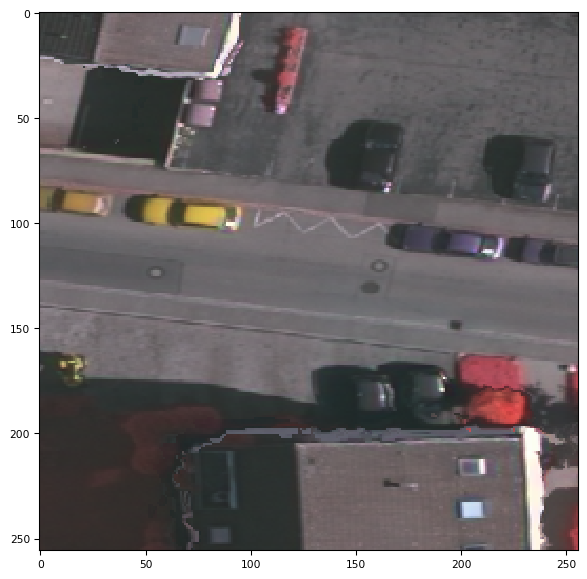

In [75]:
tiff.imshow(a)

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x2df1bd14dc0>)

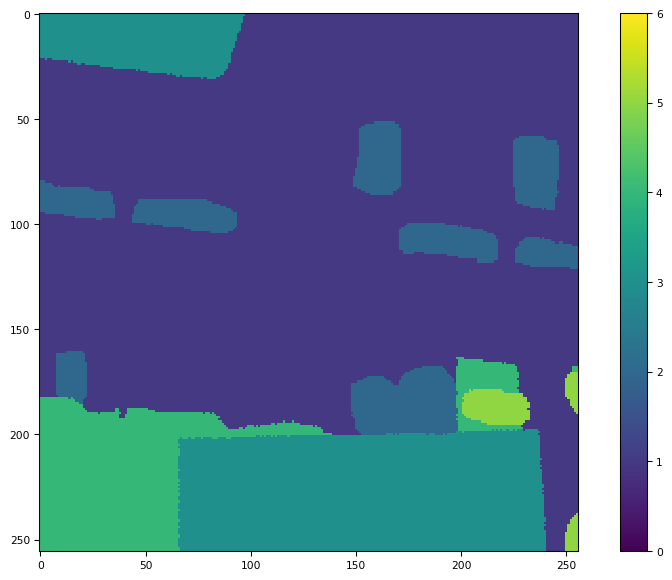

In [76]:
tiff.imshow(b, vmin=0, vmax = 6)

In [77]:
np.unique(b)

array([1, 2, 3, 4, 5], dtype=uint8)

In [78]:
im_tr = os.listdir('C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\training\\imgs')
mask_tr = os.listdir('C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\training\\masks')
im_val = os.listdir('C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\validation\\imgs')
mask_val = os.listdir('C:\\Users\\vmars\\Desktop\\phd\\dataset\\Vaihingen\\dataset\\validation\\masks')

In [79]:
print(len(im_tr), len(mask_tr), len(im_val), len(mask_val))

368 368 196 196


In [81]:
im_mask = []
for im in tqdm(im_tr):
    im_mask.append(im[:-4] + '-mask.npy')
    
    
set(im_mask) - set(mask_tr)

100%|██████████| 368/368 [00:00<?, ?it/s]


In [83]:
im_mask = []
for im in tqdm(im_val):
    im_mask.append(im[:-4] + '-mask.npy')
    
    
set(im_mask) - set(mask_val)

100%|██████████| 196/196 [00:00<?, ?it/s]


set()

In [22]:
os.remove('')